# Pay Day Strategy

In [1]:
# Packages
import datetime as dt
import pandas as pd
import yfinance as yf

import available as avb
import utils as self_utils
from quantified_strategies import utils

C:\Users\tomw1\AppData\Local\Temp\ipykernel_12320\784884138.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
def get_data(ticker: str) -> pd.DataFrame:
    px = utils.get_data(ticker=ticker, columns="Adj Close")
    px = px.to_frame(name=ticker)
    return px


## Rules

1. Buy the close on the fifth last trading day of the month; and,
2. Sell at the close of the first trading day of the new month. 

In [3]:
BUY_LAST_N_TRADING_DAYS = 5
# NOTE: different to rules
SELL_FIRST_N_TRADING_DAYS = 3

# Interactive Brokers (Cost per share)
COST = 0.005

START = dt.date(2020, 1, 1)
END = dt.date.today()

In [34]:
TICKER = "IWM"
# TICKER = "SPY"
# TICKER = "QQQ"
# TICKER = "^FCHI"

### Get Data

In [35]:
data = get_data(ticker=TICKER)
data.head(5)

,QQQ
Date,
1999-03-10,43.604977
1999-03-11,43.818485
1999-03-12,42.751026
1999-03-15,43.978592
1999-03-16,44.352200


In [36]:
data = data.loc[(data.index.date >= START) & (data.index.date <= END)]

### Set-up to get data

In [37]:
data["year_month"] = data.index.map(lambda date: float(dt.datetime.strftime(date, "%Y.%m")))

### Get exit trading day of each month

In [38]:
first_n_trading_days_in_month = data.reset_index(names="exit_date").groupby("year_month").head(SELL_FIRST_N_TRADING_DAYS)
nth_first_trading_day_in_month = first_n_trading_days_in_month.groupby("year_month").last()
nth_first_trading_day_in_month = nth_first_trading_day_in_month.rename(columns={TICKER: "exit"})
nth_first_trading_day_in_month.head(5)

,exit_date,exit
year_month,,
2020.01,2020-01-06,210.298523
2020.02,2020-02-05,222.649475
2020.03,2020-03-04,212.893585
2020.04,2020-04-03,179.275436
2020.05,2020-05-05,212.799759


### Get enter trading day of each month

In [39]:
last_n_trading_days_in_month = data.reset_index(names="enter_date").groupby("year_month").tail(BUY_LAST_N_TRADING_DAYS)
nth_last_trading_day_in_month = last_n_trading_days_in_month.groupby("year_month").first()
nth_last_trading_day_in_month.head(5)

,enter_date,QQQ
year_month,,
2020.01,2020-01-27,212.776489
2020.02,2020-02-24,215.986221
2020.03,2020-03-25,178.229370
2020.04,2020-04-24,209.065079
2020.05,2020-05-22,224.531830


In [40]:
nth_last_trading_day_in_month_shifted = nth_last_trading_day_in_month.shift(1)
nth_last_trading_day_in_month_shifted = nth_last_trading_day_in_month_shifted.rename(columns={TICKER: "enter"})
nth_last_trading_day_in_month_shifted.head(5)

,enter_date,enter
year_month,,
2020.01,NaT,NaN
2020.02,2020-01-27,212.776489
2020.03,2020-02-24,215.986221
2020.04,2020-03-25,178.229370
2020.05,2020-04-24,209.065079


### Join data

In [41]:
df = pd.concat([nth_last_trading_day_in_month_shifted, nth_first_trading_day_in_month], axis=1)
df = df.dropna()
df.index = df.index.map(lambda year_month: dt.datetime.strptime(f"{year_month:.2f}", "%Y.%m"))
df = df.sort_index()
df.tail(5)

,enter_date,enter,exit_date,exit
year_month,,,,
2023-10-01,2023-09-25,358.704468,2023-10-04,358.844116
2023-11-01,2023-10-25,349.457825,2023-11-03,366.784088
2023-12-01,2023-11-24,388.529175,2023-12-05,386.314758
2024-01-01,2023-12-22,408.165314,2024-01-04,396.279999
2024-02-01,2024-01-25,426.350006,2024-02-05,428.450012


In [42]:
pos = pd.Series(0, index=data.index)
for i, row in df.iterrows():
    pos[row["enter_date"]:row["exit_date"]] = 1
data["ret"] = data[TICKER].pct_change()

### Calculate Returns

In [43]:
df["strat_ret"] = (df["exit"] - 0 * 2 * COST) / df["enter"] - 1
df["cum_strat_ret"] = utils.get_cumulative_return(returns=df["strat_ret"], total=False)
df

,enter_date,enter,exit_date,exit,strat_ret,cum_strat_ret
year_month,,,,,,
2020-02-01,2020-01-27,212.776489,2020-02-05,222.649475,0.046401,0.046401
2020-03-01,2020-02-24,215.986221,2020-03-04,212.893585,-0.014319,0.031418
2020-04-01,2020-03-25,178.229370,2020-04-03,179.275436,0.005869,0.037471
2020-05-01,2020-04-24,209.065079,2020-05-05,212.799759,0.017864,0.056004
2020-06-01,2020-05-22,224.531830,2020-06-03,231.404831,0.030610,0.088329
2020-07-01,2020-06-24,238.682434,2020-07-06,253.059631,0.060236,0.153885
2020-08-01,2020-07-27,254.753906,2020-08-05,265.458435,0.042019,0.202371
2020-09-01,2020-08-25,279.962891,2020-09-03,281.480957,0.005422,0.208890
2020-10-01,2020-09-24,259.915192,2020-10-05,274.380524,0.055654,0.276170


### Plot Strategy Returns

In [44]:
import matplotlib.pyplot as plt

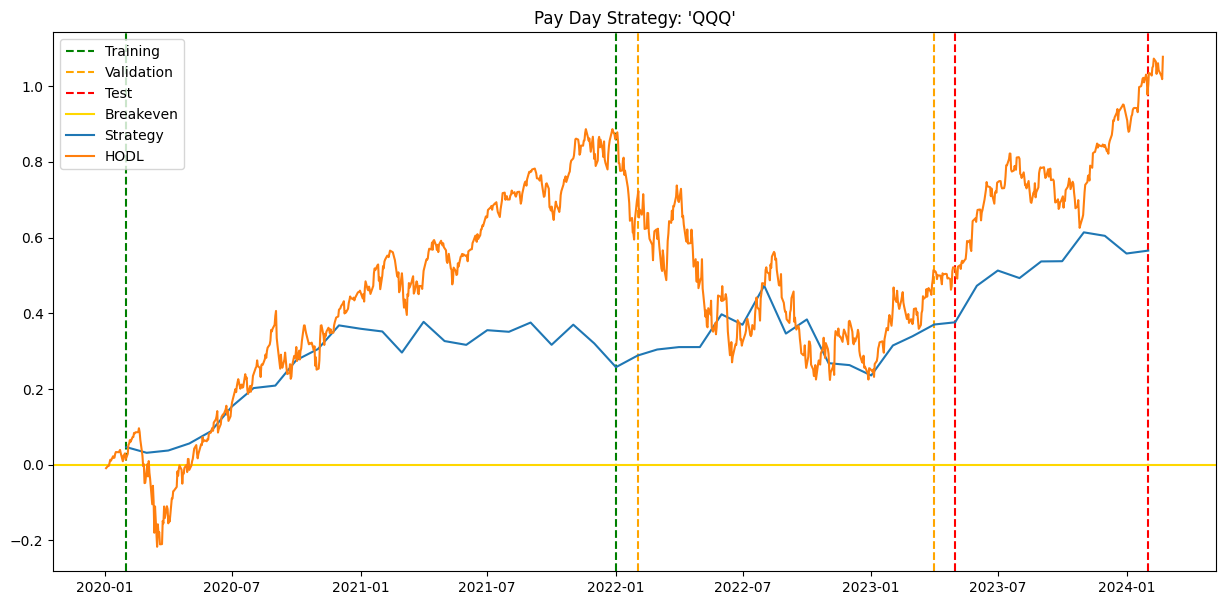

In [45]:
train_dates = utils.get_training(df["strat_ret"]).index.tolist()
valid_dates = utils.get_validation(df["strat_ret"]).index.tolist()
test_dates = utils.get_test(df["strat_ret"]).index.tolist()

fig, ax = plt.subplots(figsize=(15, 7))

ax.axvline(x=train_dates[0], label="Training", color="green", linestyle="--")
ax.axvline(x=train_dates[-1], color="green", linestyle="--")
ax.axvline(x=valid_dates[0], label="Validation", color="orange", linestyle="--")
ax.axvline(x=valid_dates[-1], color="orange", linestyle="--")
ax.axvline(x=test_dates[0], label="Test", color="red", linestyle="--")
ax.axvline(x=test_dates[-1], color="red", linestyle="--")

ax.axhline(y=0, label="Breakeven", color="gold")

ax.plot(df["cum_strat_ret"], label="Strategy")
ax.plot(utils.get_cumulative_return(returns=data[TICKER].pct_change(), total=False), label="HODL")

plt.title(f"Pay Day Strategy: {TICKER!r}")
plt.legend(loc="best")
plt.show()

In [46]:
train_returns = utils.get_training(data["ret"])
valid_returns = utils.get_validation(data["ret"])
test_returns = utils.get_test(data["ret"])

description = pd.concat([
    utils.describe(returns=data.loc[data.index.isin(train_returns.index), "ret"] * pos.loc[pos.index.isin(train_returns.index)],
                   pos=pos.loc[pos.index.isin(train_returns.index)], daily=True, asset=TICKER).to_frame(name="daily_strat_train"),
    # utils.describe(returns=df.loc[(df["enter_date"] >= train_returns.index[0]) & (df["exit_date"] <= train_returns.index[-1]), "strat_ret"],
    #                daily=True, asset=TICKER).to_frame(name="trade_strat_train"),
    utils.describe(returns=train_returns, daily=True, asset=TICKER).to_frame(name="hodl_train"),
    
    utils.describe(returns=data.loc[data.index.isin(valid_returns.index), "ret"] * pos.loc[pos.index.isin(valid_returns.index)],
                   pos=pos.loc[pos.index.isin(valid_returns.index)], daily=True, asset=TICKER).to_frame(name="daily_strat_valid"),
    # utils.describe(returns=df.loc[(df["enter_date"] >= valid_returns.index[0]) & (df["exit_date"] <= valid_returns.index[-1]), "strat_ret"],
    #                daily=True, asset=TICKER).to_frame(name="trade_strat_valid"),
    utils.describe(returns=valid_returns, daily=True, asset=TICKER).to_frame(name="hodl_valid"),
    
    utils.describe(returns=data.loc[data.index.isin(test_returns.index), "ret"] * pos.loc[pos.index.isin(test_returns.index)],
                   pos=pos.loc[pos.index.isin(test_returns.index)], daily=True, asset=TICKER).to_frame(name="daily_strat_test"),
    # utils.describe(returns=df.loc[(df["enter_date"] >= test_returns.index[0]) & (df["exit_date"] <= test_returns.index[-1]), "strat_ret"],
    #                daily=True, asset=TICKER).to_frame(name="trade_strat_test"),
    utils.describe(returns=test_returns, daily=True, asset=TICKER).to_frame(name="hodl_test"),
], axis=1)
description

,daily_strat_train,hodl_train,daily_strat_valid,hodl_valid,daily_strat_test,hodl_test
Asset,QQQ,QQQ,QQQ,QQQ,QQQ,QQQ
Start,2020-01-02,2020-01-02,2022-01-25,2022-01-25,2023-04-25,2023-04-25
End,2022-01-24,2022-01-24,2023-04-24,2023-04-24,2024-02-22,2024-02-22
Mean Return,0.12519%,0.11266%,0.10603%,-0.01485%,0.14561%,0.16440%
Total Return,23.83%,65.17%,11.22%,-9.77%,11.66%,39.39%
Median Return,0.30377%,0.23983%,-0.11982%,-0.08340%,0.12714%,0.13976%
1st Quartile,-0.45963%,-0.62445%,-1.20113%,-1.22869%,-0.51296%,-0.45048%
3rd Quartile,1.04267%,0.95664%,1.66634%,1.39170%,0.75271%,0.82632%
Std Dev Return,1.66429%,1.77996%,1.91205%,1.90006%,1.09904%,1.03825%
CAGR,11.138 bps,9.654 bps,8.793 bps,-3.285 bps,13.966 bps,15.904 bps


In [47]:
description = pd.concat([
    utils.describe(returns=df.loc[(df["enter_date"] >= train_returns.index[0]) & (df["exit_date"] <= train_returns.index[-1]), "strat_ret"],
                   daily=True, asset=TICKER).to_frame(name="trade_strat_train"),
    utils.describe(returns=df.loc[(df["enter_date"] >= valid_returns.index[0]) & (df["exit_date"] <= valid_returns.index[-1]), "strat_ret"],
                   daily=True, asset=TICKER).to_frame(name="trade_strat_valid"),
    utils.describe(returns=df.loc[(df["enter_date"] >= test_returns.index[0]) & (df["exit_date"] <= test_returns.index[-1]), "strat_ret"],
                   daily=True, asset=TICKER).to_frame(name="trade_strat_test"),
], axis=1)
description

,trade_strat_train,trade_strat_valid,trade_strat_test
Asset,QQQ,QQQ,QQQ
Start,2020-02-01,2022-02-01,2023-06-01
End,2022-01-01,2023-04-01,2024-02-01
Mean Return,1.01701%,0.67888%,1.48665%
Total Return,25.75%,8.96%,13.76%
Median Return,1.18665%,1.23640%,0.49255%
1st Quartile,-1.09337%,-1.97208%,-0.94367%
3rd Quartile,4.11853%,2.77365%,3.95147%
Std Dev Return,3.47830%,4.71227%,3.17744%
CAGR,95.935 bps,57.386 bps,144.275 bps


In [48]:
utils.describe(returns=df["strat_ret"], daily=True, asset=TICKER)

Asset                           QQQ
Start                    2020-02-01
End                      2024-02-01
Mean Return                0.98766%
Total Return                 56.54%
Median Return              0.58692%
1st Quartile              -1.03613%
3rd Quartile               3.54809%
Std Dev Return             3.74701%
CAGR                     91.875 bps
Trade CAGR                      N/A
Ann. CAGR                  902.097%
Activity Ratio              100.00%
Number of Trades                0.0
Average Hold Period      49.00 Days
Daily Sharpe Ratio           0.2636
Ann. Sharpe Ratio            4.1843
Daily Sortino Ratio          0.3893
Ann. Sortino Ratio           6.1792
Daily Calmar Ratio            3.512
Hit Ratio                    63.27%
Profit Factor                 1.96x
MDD                         -16.10%
MDD Start                2022-08-01
MDD Bottom               2023-01-01
MDD End                  2023-07-01
MDD Decline Duration         6 Days
MDD Recovery Duration       